In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hankel2
from typing import Any
from numpy import dtype, floating, ndarray
from numpy._typing import _64Bit

## Forward Scattering

In [2]:
def circle_data(a: float, N: int, cx: float = 0.0, cy: float = 0.0) -> np.ndarray:
    """
    Calculate coordinates, lengths, angles, and normals for points on a circle.

    Args:
        a (float): Radius of the circle.
        N (int): Number of points to generate.
        cx (float): x-coordinate of the center of the circle. Default is 0.0.
        cy (float): y-coordinate of the center of the circle. Default is 0.0.

    Returns:
        numpy.ndarray: Array containing coordinates (x, y), lengths, angles,
                       and normals for each point.
    """
    data = np.zeros((N, 2))
    # Calculate coordinates xn, yn
    for i in range(N):
        theta = (2 * np.pi / N) * i
        xn = cx + a * np.cos(theta)
        yn = cy + a * np.sin(theta)
        data[i, 0] = xn
        data[i, 1] = yn
    # Duplicate first row at the end for circularity
    circular_data = np.vstack((data[1:], data[0]))
    data = np.hstack((data, circular_data))  
    return data

def kite_data(a: float, N: int, cx: float = 0.0, cy: float = 0.0) -> np.ndarray:
    """
    Generate coordinates for points on a kite shape.

    Args:
        a (float): Scaling factor for the kite.
        N (int): Number of points to generate.
        cx (float): x-coordinate of the center of the kite. Default is 0.0.
        cy (float): y-coordinate of the center of the kite. Default is 0.0.

    Returns:
        numpy.ndarray: Array containing coordinates (x, y) of the kite points.
    """
    data = np.zeros((N, 2))
    for i in range(N):
        theta = (2 * np.pi / N) * i
        x = cx + a * (np.cos(theta) + 0.65 * np.cos(2*theta) - 0.65)
        y = cy + a * np.sin(theta)
        data[i, 0] = x
        data[i, 1] = y
    
    # Duplicate first row at the end for circularity
    circular_data = np.vstack((data[1:], data[0]))
    data = np.hstack((data, circular_data))
    return data

def rectangle_data(a: float, b: float, N: int, cx: float = 0.0, cy: float = 0.0) -> np.ndarray:
    """
    Generate coordinates for points on a rectangle.

    Args:
        a (float): Length of the rectangle along the x-axis.
        b (float): Length of the rectangle along the y-axis.
        N (int): Number of points to generate.
        cx (float): x-coordinate of the center of the rectangle. Default is 0.0.
        cy (float): y-coordinate of the center of the rectangle. Default is 0.0.

    Returns:
        numpy.ndarray: Array containing coordinates (x, y) of the rectangle points.
    """
    data = np.zeros((N, 2))
    # Points on the top side
    data[:N//4, 0] = np.linspace(cx - a/2, cx + a/2, N//4)
    data[:N//4, 1] = cy + b/2
    # Points on the right side
    data[N//4:N//2, 0] = cx + a/2
    data[N//4:N//2, 1] = np.linspace(cy + b/2, cy - b/2, N//4)
    # Points on the bottom side
    data[N//2:3*N//4, 0] = np.linspace(cx + a/2, cx - a/2, N//4)
    data[N//2:3*N//4, 1] = cy - b/2
    # Points on the left side
    data[3*N//4:, 0] = cx - a/2
    data[3*N//4:, 1] = np.linspace(cy - b/2, cy + b/2, N//4)
    
    return data

def is_inside_kite(x: np.ndarray, y: np.ndarray, data: np.ndarray) -> bool:
    """
    Check if the given point (x, y) is inside the geometry defined by data.

    Args:
        x (np.ndarray): Array of x-coordinates of the points.
        y (np.ndarray): Array of y-coordinates of the points.
        data (np.ndarray): Array defining the geometry.

    Returns:
        bool: True if the point is inside the geometry, False otherwise.
    """
    n = len(data)
    inside = False
    for i in range(n):
        j = (i + 1) % n
        if ((data[i, 1] > y) != (data[j, 1] > y)) and \
                (x < (data[j, 0] - data[i, 0]) * (y - data[i, 1]) / (data[j, 1] - data[i, 1]) + data[i, 0]):
            inside = not inside
    return inside

def is_inside_rectangle(x: np.ndarray, y: np.ndarray, data: np.ndarray) -> bool:
    """
    Check if points (x, y) are inside a rectangle defined by data.

    Parameters:
        x (np.ndarray): X-coordinates of the points.
        y (np.ndarray): Y-coordinates of the points.
        data (np.ndarray): Vertices of the rectangle (2x2 array).

    Returns:
        bool: True if points are inside the rectangle, False otherwise.
    """
    x_min, x_max = data[:, 0].min(), data[:, 0].max()
    y_min, y_max = data[:, 1].min(), data[:, 1].max()

    inside = np.logical_and(x >= x_min, x <= x_max)
    inside = np.logical_and(inside, y >= y_min)
    inside = np.logical_and(inside, y <= y_max)
    
    return np.all(inside)

In [3]:
def calculate_current_distribution_aux_sources(data_contour: np.ndarray, data_aux: np.ndarray, phi_i: float) -> np.ndarray:
    """
    Calculate the current distribution for auxiliary sources.

    Args:
        data_contour: Contour data.
        data_aux: Auxiliary sources data.
        phi_i: Angle of incidence in degrees.

    Returns:
        ndarray: Current distribution for auxiliary sources.
    """
    k = 2 * np.pi  # Wavenumber
    phi_i = np.deg2rad(phi_i)  # Angle of incidence in radians
    M = len(data_contour)  # Number of segments
    N = len(data_aux)  # Number of auxiliary sources
    Z = np.zeros((M, N), dtype=complex)  # Impedance matrix
    V = np.zeros((M, 1), dtype=complex)  # Excitation vector
    
    # Calculate impedance matrix
    for l in range(N):
        xm, ym = data_aux[l, 0], data_aux[l, 1]
        for m in range(M):
            xl, yl = data_contour[m, 0], data_contour[m, 1]
            rml = np.sqrt((xm - xl)**2 + (ym - yl)**2)
            Z[m, l] += hankel2(0, k * rml)

    # Calculate excitation vector
    for i in range(M):
        xm = data_contour[i, 0]
        ym = data_contour[i, 1]
        V[i] = np.exp(1j * k * (xm * np.cos(phi_i) + ym * np.sin(phi_i)))
    
    # Solve the least squares problem
    I, residuals, _, _ = np.linalg.lstsq(Z, -V, rcond=0.01)
    
    return I

In [4]:
def scattered_field(data: np.ndarray, I: np.ndarray, xn_grid: np.ndarray, yn_grid: np.ndarray) -> ndarray[Any, dtype[Any]]:
    """
    Calculate the scattered field at observation points.

    Args:
        data: Auxiliary sources data.
        I: Current distribution.
        xn_grid: x-coordinates of observation points.
        yn_grid: y-coordinates of observation points.

    Returns:
        ndarray: Scattered field at observation points.
    """
    k = 2 * np.pi  # Wavenumber
    N = len(data)
    M = len(xn_grid)
    e_scat = np.zeros((M, M), dtype=complex)  # Initialize scattered field vector
    
    for i in range(M):
        xn = xn_grid[i]
        yn = yn_grid[i]
        for j in range(N):
            xm = data[j, 0]  # x-coordinate of the point on the contour
            ym = data[j, 1]  # y-coordinate of the point on the contour
            r = np.sqrt((xn - xm)**2 + (yn - ym)**2)
            e_scat[i] += hankel2(0, k * r) * I[j,0]
    return e_scat

def incident_field(xn_grid: np.ndarray, yn_grid: np.ndarray, phi_inc: float) -> ndarray[Any, dtype[Any]]:
    """
    Calculate the incident field at observation points.

    Args:
        xn_grid: x-coordinates of observation points.
        yn_grid: y-coordinates of observation points.
        phi_inc: Angle of incidence.

    Returns:
        ndarray: Incident field at observation points.
    """
    k = 2 * np.pi 
    N = len(xn_grid)
    phi_inc = np.deg2rad(phi_inc)  # Angle of incidence in radians
    e_inc = np.zeros((N, N), dtype=complex)  # Initialize incident field vector
    
    for i in range(N):
        xn = xn_grid[i]
        yn = yn_grid[i]
        e_inc[i] = np.exp(1j * k * (xn * np.cos(phi_inc) + yn * np.sin(phi_inc)))
    return e_inc   

def scattered_field_obs(data: np.ndarray, I: np.ndarray, xn_grid: np.ndarray, yn_grid: np.ndarray) -> ndarray[Any, dtype[Any]]:
    """
    Calculate the scattered field at observation points.

    Args:
        data: Auxiliary sources data.
        I: Current distribution.
        xn_grid: x-coordinates of observation points.
        yn_grid: y-coordinates of observation points.

    Returns:
        ndarray: Scattered field at observation points.
    """
    k = 2 * np.pi  # Wavenumber
    N = len(xn_grid)
    M = len(data)
    e_scat = np.zeros((N,1), dtype=complex)  # Initialize scattered field vector

    for i in range(N):
        xn = xn_grid[i]
        yn = yn_grid[i]
        for j in range(M):
            xm = data[j, 0]  # x-coordinate of the point on the contour
            ym = data[j, 1]  # y-coordinate of the point on the contour
            r = np.sqrt((xn - xm)**2 + (yn - ym)**2)
            e_scat[i,0] += hankel2(0, k * r) * I[j,0]
    return e_scat


In [5]:
# Plot the current distribution on the contour
a_contour = 3
a_aux = a_contour*0.9
M = 20*int(2*np.pi*a_contour)
N = 10*int(2*np.pi*a_contour)
data_contour = circle_data(a_contour, M)
data_aux = circle_data(a_aux, N)
phi_i = 0   # Angle of incidence in degrees

print("Number of matching points on the circle: ", M)
print("Number of auxiliary sources: ", N)

# Define the grid
grid_size = 500  # Size of the grid
x_min, x_max = -6, 6  # X-coordinate range
y_min, y_max = -6, 6  # Y-coordinate range

x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))

# Calculate distance of each grid point from the center of the circle
distance_to_center = np.sqrt((x_grid)**2 + (y_grid)**2)

# Remove points within the circular region
mask = distance_to_center < a_contour
x_grid[mask] = np.nan
y_grid[mask] = np.nan

I_circle = calculate_current_distribution_aux_sources(data_contour, data_aux, phi_i)
e_scat_aux = scattered_field(data_aux, I_circle, x_grid, y_grid)
e_inc = incident_field(x_grid, y_grid, phi_i)
e_total = e_inc + e_scat_aux

Number of matching points on the circle:  360
Number of auxiliary sources:  180


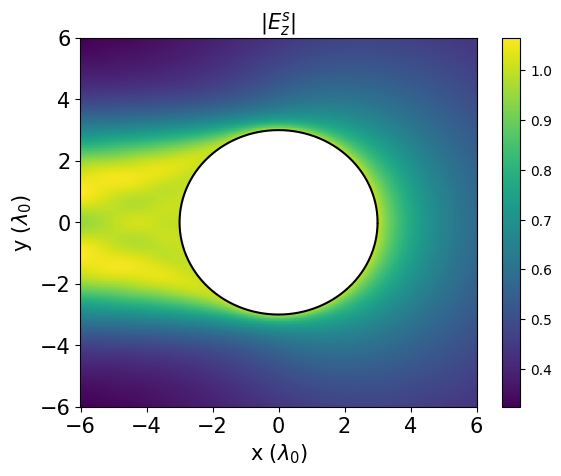

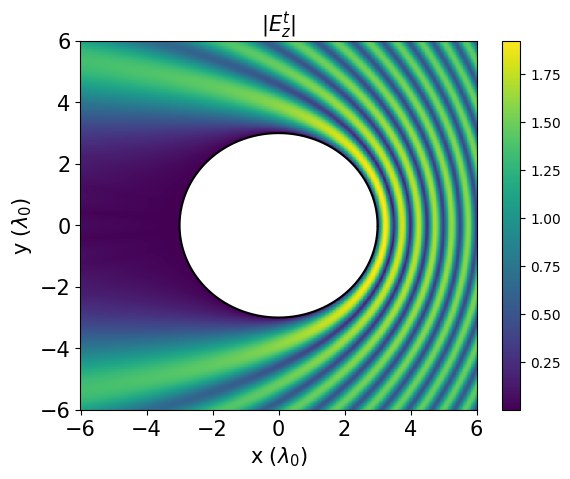

In [6]:
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))
plt.figure()
plt.pcolormesh(x_grid, y_grid, np.abs(e_scat_aux), shading='auto')
plt.title(r'|$E^{s}_{z}$|', fontsize=15)
plt.colorbar()
plt.plot(data_contour[:, 0], data_contour[:, 1], color='black')  # Plot contour of the scatterer
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

plt.figure()
plt.pcolormesh(x_grid, y_grid, np.abs(e_total), shading='auto')
plt.title(r'|$E^{t}_{z}$|', fontsize=15)
plt.colorbar()
plt.plot(data_contour[:, 0], data_contour[:, 1], color='black')  # Plot contour of the scatterer
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [7]:
a_kite = 3
a_aux = a_kite*0.6
P = 30*int(2*np.pi*a_kite)
N = 15*int(2*np.pi*a_kite)
data_kite = kite_data(a_kite, P)
data_aux = circle_data(a_aux, N, cx=-0.5, cy=0.0)
print("Number of matching points on the kite: ", P)
print("Number of auxiliary sources: ", N)

phi_i = [0]
J = len(phi_i)

grid_size = 300  # Size of the grid
x_min, x_max = -6, 6  # X-coordinate range
y_min, y_max = -6, 6  # Y-coordinate range


x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))

mask = np.zeros_like(x_grid, dtype=bool)
for i in range(grid_size):
    for j in range(grid_size):
        mask[i, j] = is_inside_kite(x_grid[i, j], y_grid[i, j], data_kite)

x_grid[mask] = np.nan
y_grid[mask] = np.nan

e_scat_aux_kite = np.zeros((grid_size, grid_size), dtype=complex)
e_inc_kite = np.zeros((grid_size, grid_size), dtype=complex)
e_total_kite = np.zeros((grid_size, grid_size), dtype=complex)
for i in range(J):
    I_kite = calculate_current_distribution_aux_sources(data_kite, data_aux, phi_i[i])
    e_scat_aux_kite += scattered_field(data_aux, I_kite, x_grid, y_grid)
    e_inc_kite += incident_field(x_grid, y_grid, phi_i[i])
e_total_kite = e_inc_kite + e_scat_aux_kite

Number of matching points on the kite:  540
Number of auxiliary sources:  270


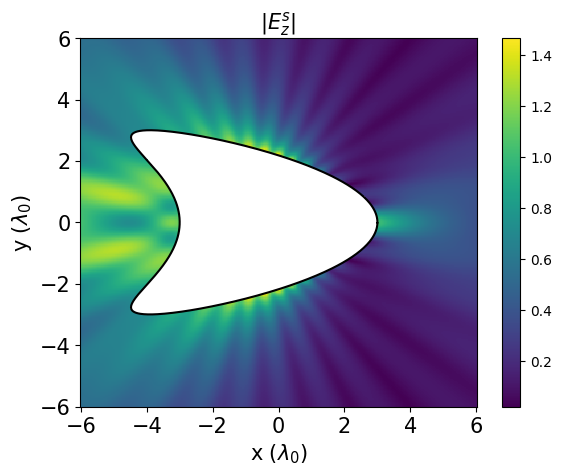

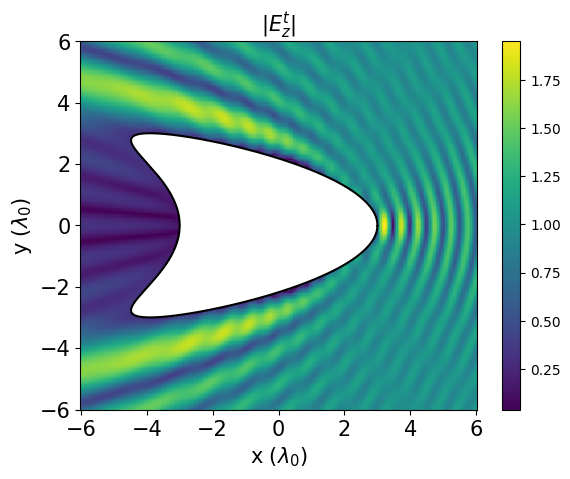

In [8]:
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))
plt.figure()
plt.pcolormesh(x_grid, y_grid, np.abs(e_scat_aux_kite), shading='auto')
plt.title(r'|$E^{s}_{z}$|', fontsize=15)
plt.colorbar()
plt.plot(data_kite[:, 0], data_kite[:, 1], color='black')  # Plot contour of the scatterer
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

plt.figure()
plt.pcolormesh(x_grid, y_grid, np.abs(e_total_kite), shading='auto')
plt.title(r'|$E^{t}_{z}$|', fontsize=15)
plt.colorbar()
plt.plot(data_kite[:, 0], data_kite[:, 1], color='black')  # Plot contour of the scatterer
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [34]:
a = 5  # Length of the rectangle along the x-axis
b = 5  # Length of the rectangle along the y-axis
cx = 0  # x-coordinate of the center of the rectangle
cy = 0  # y-coordinate of the center of the rectangle

# Find the radius inside the rectangle that is tangent to the circle
if a < b:
    a_aux = a*0.9/2
else:
    a_aux = b*0.9/2

N = 15*int(2*np.pi*a_aux)
P = 2*N
data_rectangle = rectangle_data(a, b, P, cx, cy)
data_aux = circle_data(a_aux, N, cx, cy)

print("Number of matching points on the rectangle: ", P)
print("Number of auxiliary sources: ", N)

phi_i = [0, 180]
J = len(phi_i)

grid_size = 300  # Size of the grid
x_min, x_max = -6, 6  # X-coordinate range
y_min, y_max = -6, 6  # Y-coordinate range
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                            np.linspace(y_min, y_max, grid_size))

mask = np.zeros_like(x_grid, dtype=bool)
for i in range(grid_size):
    for j in range(grid_size):
        mask[i, j] = is_inside_rectangle(x_grid[i, j], y_grid[i, j], data_rectangle)
x_grid[mask] = np.nan
y_grid[mask] = np.nan

e_scat_aux_rectangle = np.zeros((grid_size, grid_size), dtype=complex)
e_inc_rectangle = np.zeros((grid_size, grid_size), dtype=complex)
e_total_rectangle = np.zeros((grid_size, grid_size), dtype=complex)

e_total_rectangle_list = []
e_scat_aux_rectangle_list = []
for i in range(J):
    I_rectangle = calculate_current_distribution_aux_sources(data_rectangle, data_aux, phi_i[i])
    e_scat_aux_rectangle = scattered_field(data_aux, I_rectangle, x_grid, y_grid)
    e_inc_rectangle = incident_field(x_grid, y_grid, phi_i[i])
    e_total_rectangle = e_inc_rectangle + e_scat_aux_rectangle
    e_total_rectangle_list.append(e_total_rectangle)
    e_scat_aux_rectangle_list.append(e_scat_aux_rectangle)

Number of matching points on the rectangle:  420
Number of auxiliary sources:  210


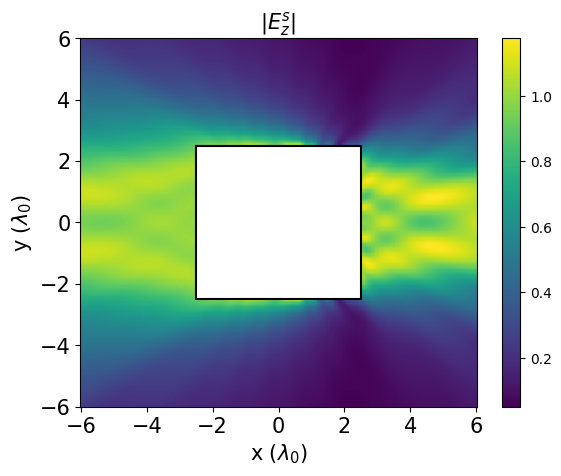

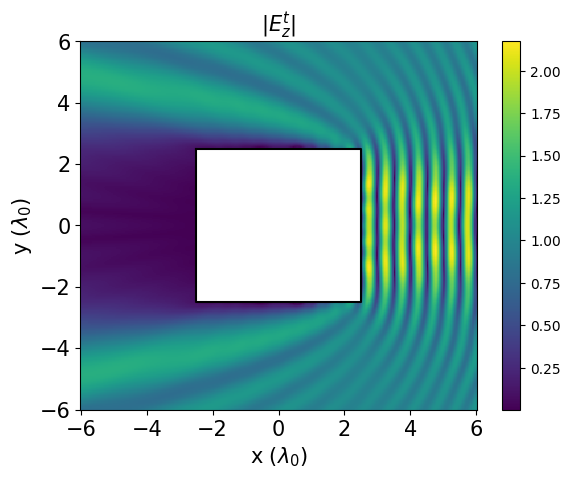

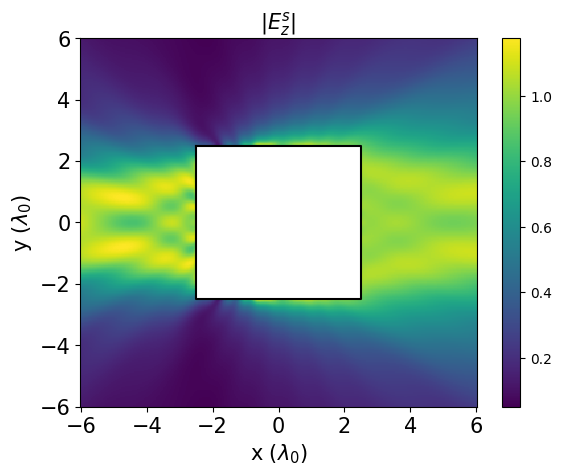

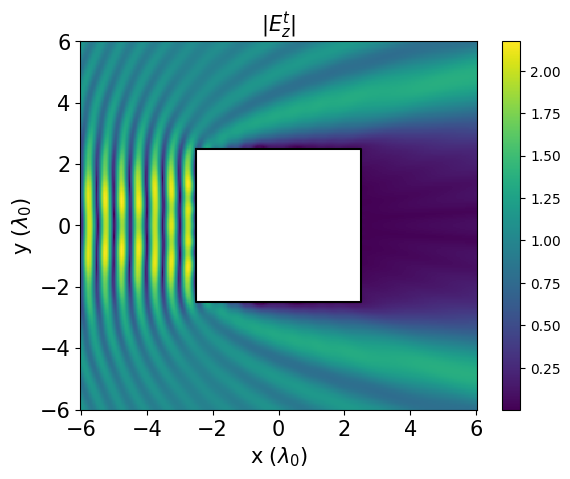

In [35]:
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                            np.linspace(y_min, y_max, grid_size))

for i in range(J):
    plt.figure()
    plt.pcolormesh(x_grid, y_grid, np.abs(e_scat_aux_rectangle_list[i]), shading='auto')
    plt.title(r'|$E^{s}_{z}$|', fontsize=15)
    plt.colorbar()
    plt.plot(data_rectangle[:, 0], data_rectangle[:, 1], color='black')  # Plot contour of the scatterer
    plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
    plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

    plt.figure()
    plt.pcolormesh(x_grid, y_grid, np.abs(e_total_rectangle_list[i]), shading='auto')
    plt.title(r'|$E^{t}_{z}$|', fontsize=15)
    plt.colorbar()
    plt.plot(data_rectangle[:, 0], data_rectangle[:, 1], color='black')  # Plot contour of the scatterer
    plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
    plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

## Inverse scattering

In [36]:
def cv_inverse_scattering(data_obs: np.ndarray, data_aux: np.ndarray, scattered_field: np.ndarray) -> ndarray[Any, dtype[Any]]:
    """
    Computes the coefficient vector (cv) for inverse scattering.

    Args:
        data_obs (ndarray): Array containing coordinates of observable points.
        data_aux (ndarray): Array containing coordinates of auxiliary sources.
        J (int): Number of iterations.
        scattered_field (ndarray): Scattered field.
        phi_i (ndarray): Angle of incidence in radians.

    Returns:
        ndarray: Coefficient vector.
    """
    M = len(data_obs)  # Number of observable points
    N = len(data_aux)  # Number of auxiliary sources
    k = 2 * np.pi  # Wavenumber
    Z = np.zeros((M, N), dtype=complex)
    cv = np.zeros((N, 1), dtype=complex)
    
    for l in range(N):
        xm = data_aux[l, 0]
        ym = data_aux[l, 1]
        for m in range(M):
            xl = data_obs[m, 0]
            yl = data_obs[m, 1]
            rml = np.sqrt((xm - xl)**2 + (ym - yl)**2)
            Z[m,l] += hankel2(0, k * rml)
        # Solve the regularized least squares problem
    cv, residuals, _, _ = np.linalg.lstsq(Z, scattered_field, rcond=0.01)

    return cv

In [37]:
def inverse_scattered_field(data: np.ndarray, I: np.ndarray, xn_grid: np.ndarray, yn_grid: np.ndarray) -> ndarray[Any, dtype[Any]]:
    """
    Calculates the inverse scattered field.

    Args:
        data (ndarray): Array containing coordinates of points on the contour.
        I (ndarray): Incident field vector.
        xn_grid (ndarray): x-coordinates grid.
        yn_grid (ndarray): y-coordinates grid.

    Returns:
        ndarray: Inverse scattered field vector.
    """
    k = 2 * np.pi  # Wavenumber
    N = len(data)
    M = len(xn_grid)
    e_inv_scat = np.zeros((M, M), dtype=complex)  # Initialize scattered field vector
    for i in range(M):
        xn = xn_grid[i]
        yn = yn_grid[i]
        for j in range(N):
            xm = data[j, 0]  # x-coordinate of the point on the contour
            ym = data[j, 1]  # y-coordinate of the point on the contour
            r = np.sqrt((xn - xm)**2 + (yn - ym)**2)
            e_inv_scat[i] += hankel2(0, k * r) * I[j]
    return e_inv_scat

In [52]:
a_obs = 8
a_aux = a_contour*0.8
M = 20*int(2*np.pi*a_aux)
N = 10*int(2*np.pi*a_aux)
data_obs = circle_data(a_obs, M)
data_aux = circle_data(a_aux, N)

print("Number of observable points on the circle: ", M)
print("Number of auxiliary sources: ", N)

x_obs = data_obs[:, 0]
y_obs = data_obs[:, 1]

phi_i = [0, 180]
J = len(phi_i)

N = 300
grid_size = N  # Size of the grid
x_min, x_max = -6, 6  # X-coordinate range
y_min, y_max = -6, 6  # Y-coordinate range

x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))

e_inv_scat = np.zeros((N, N), dtype=complex)
e_inv_inc = np.zeros((N, N), dtype=complex)
e_inv_total = np.zeros((N, N), dtype=complex)

e_inv_total_list = []
e_inv_scat_list = []
for j in range(J):
    I = calculate_current_distribution_aux_sources(data_contour, data_aux, phi_i[j])
    e_scat = scattered_field_obs(data_aux, I, x_obs, y_obs)

    cv = cv_inverse_scattering(data_obs, data_aux, e_scat)
    e_inv_scat = inverse_scattered_field(data_aux, cv, x_grid, y_grid)
    e_inv_inc = incident_field(x_grid, y_grid, phi_i[j])
    e_inv_total = e_inv_inc + e_inv_scat
    e_inv_total_list.append(e_inv_total)
    e_inv_scat_list.append(e_inv_scat)

Number of observable points on the circle:  300
Number of auxiliary sources:  150


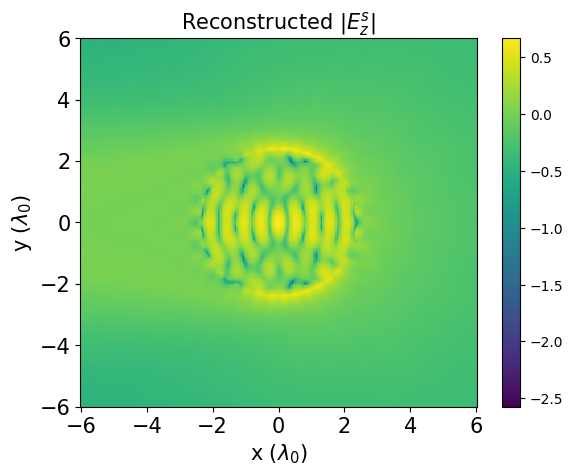

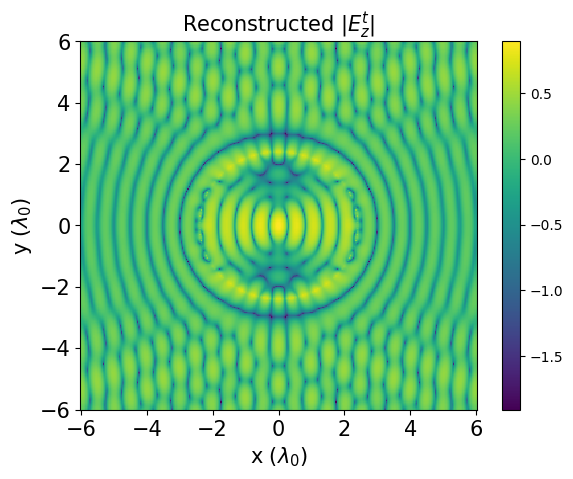

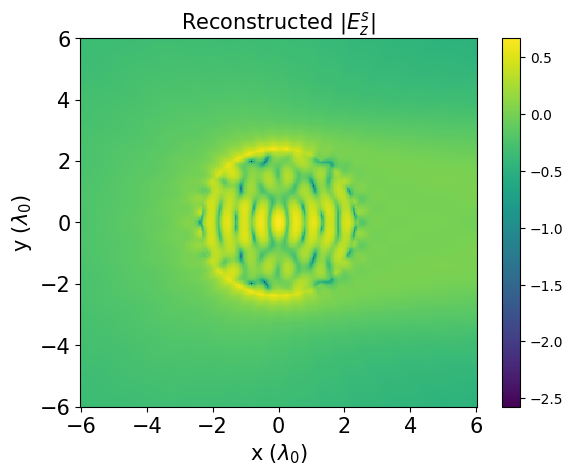

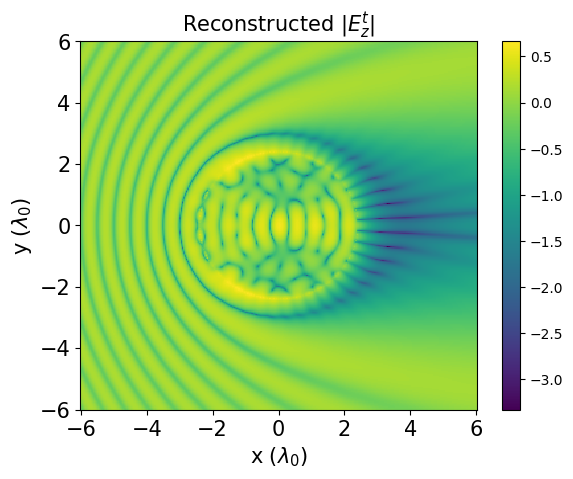

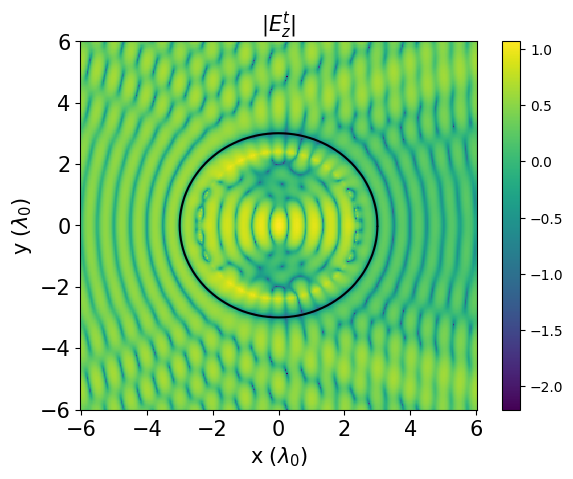

In [54]:
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))
    
for i in range(J):
    plt.figure()
    plt.pcolormesh(x_grid, y_grid, np.log10(np.abs(e_inv_scat_list[i])), shading='auto')
    plt.title(r'Reconstructed |$E^{s}_{z}$|', fontsize=15)
    plt.colorbar()
    plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
    plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

    plt.figure()
    plt.pcolormesh(x_grid, y_grid, np.log10(np.abs(e_inv_total_list[i])), shading='auto')
    plt.title(r'Reconstructed |$E^{t}_{z}$|', fontsize=15)
    plt.colorbar()
    plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
    plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

for i in range(J):
    if i == 0:
        e_total_rectangle_sum = e_inv_total_list[i]
    else:
        e_total_rectangle_sum += e_inv_total_list[i]
plt.figure()
plt.pcolormesh(x_grid, y_grid, np.log10(np.abs(e_total_rectangle_sum)), shading='auto')
plt.plot(data_contour[:, 0], data_contour[:, 1], color='black')  # Plot contour of the scatterer
plt.title(r'|$E^{t}_{z}$|', fontsize=15)
plt.colorbar()
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [38]:
a_obs = 8
a_aux = a_kite * 0.6
M = 30*int(2*np.pi*a_aux)
N = 20*int(2*np.pi*a_obs)
data_obs = circle_data(a_obs, N)
data_aux = circle_data(a_aux, M, cx = -1.0, cy = 0.0)
x_obs = data_obs[:, 0]
y_obs = data_obs[:, 1]

phi_i = [0, 145, 180, 235]
J = len(phi_i)

print("Number of auxiliary sources: ", M)
print("Number of observation points: ", N)

N = 300
grid_size = N  # Size of the grid
x_min, x_max = -6, 6  # X-coordinate range
y_min, y_max = -6, 6  # Y-coordinate range

x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))

e_inv_scat = np.zeros((N, N), dtype=complex)
e_inv_inc = np.zeros((N, N), dtype=complex)
e_inv_total = np.zeros((N, N), dtype=complex)

e_inv_total_list = []
e_inv_scat_list = []
for j in range(J):
    I = calculate_current_distribution_aux_sources(data_kite, data_aux, phi_i[j])
    e_scat = scattered_field_obs(data_aux, I, x_obs, y_obs)

    cv = cv_inverse_scattering(data_obs, data_aux, e_scat)
    e_inv_scat = inverse_scattered_field(data_aux, cv, x_grid, y_grid)
    e_inv_inc = incident_field(x_grid, y_grid, phi_i[j])
    e_inv_total = e_inv_inc + e_inv_scat
    e_inv_total_list.append(e_inv_total)
    e_inv_scat_list.append(e_inv_scat)


Number of auxiliary sources:  330
Number of observation points:  1000


In [55]:
a_obs = 8
if a < b:
    a_aux = a*0.8/2
else:
    a_aux = b*0.8/2

M = 30*int(2*np.pi*a_aux)
N = 20*int(2*np.pi*a_obs)
data_obs = circle_data(a_obs, N)
data_aux = circle_data(a_aux, M, cx = 0.0, cy = 0.0)
x_obs = data_obs[:, 0]
y_obs = data_obs[:, 1]

phi_i = [60]
J = len(phi_i)

print("Number of auxiliary sources: ", M)
print("Number of observation points: ", N)

N = 300
grid_size = N  # Size of the grid
x_min, x_max = -6, 6  # X-coordinate range
y_min, y_max = -6, 6  # Y-coordinate range

x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))

e_inv_scat = np.zeros((N, N), dtype=complex)
e_inv_inc = np.zeros((N, N), dtype=complex)
e_inv_total = np.zeros((N, N), dtype=complex)

e_inv_total_list = []
e_inv_scat_list = []
for j in range(J):
    I = calculate_current_distribution_aux_sources(data_rectangle, data_aux, phi_i[j])
    e_scat = scattered_field_obs(data_aux, I, x_obs, y_obs)

    cv = cv_inverse_scattering(data_obs, data_aux, e_scat)
    e_inv_scat = inverse_scattered_field(data_aux, cv, x_grid, y_grid)
    e_inv_inc = incident_field(x_grid, y_grid, phi_i[j])
    e_inv_total = e_inv_inc + e_inv_scat
    e_inv_total_list.append(e_inv_total)
    e_inv_scat_list.append(e_inv_scat)


Number of auxiliary sources:  360
Number of observation points:  1000


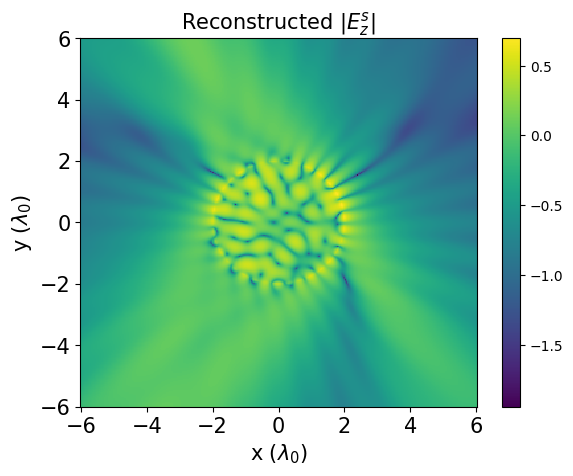

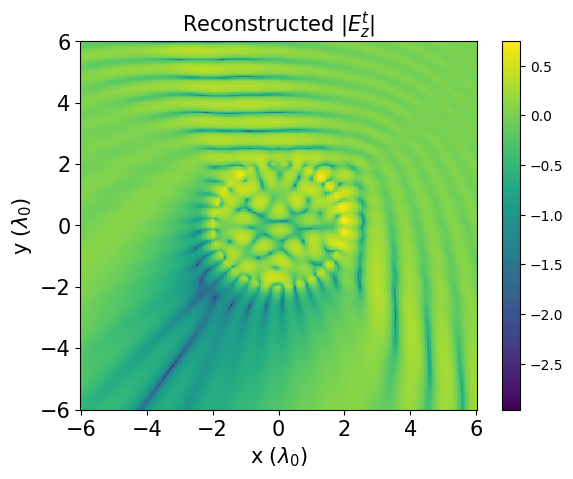

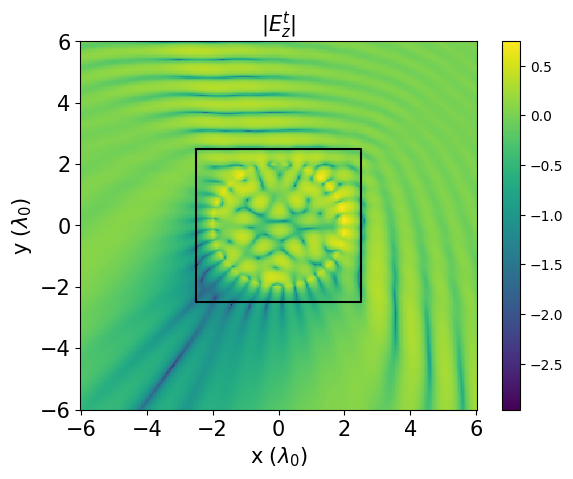

In [56]:
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))
    
for i in range(J):
    plt.figure()
    plt.pcolormesh(x_grid, y_grid, np.log10(np.abs(e_inv_scat_list[i])), shading='auto')
    plt.title(r'Reconstructed |$E^{s}_{z}$|', fontsize=15)
    plt.colorbar()
    plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
    plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

    plt.figure()
    plt.pcolormesh(x_grid, y_grid, np.log10(np.abs(e_inv_total_list[i])), shading='auto')
    plt.title(r'Reconstructed |$E^{t}_{z}$|', fontsize=15)
    plt.colorbar()
    plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
    plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

for i in range(J):
    if i == 0:
        e_total_rectangle_sum = e_inv_total_list[i]
    else:
        e_total_rectangle_sum += e_inv_total_list[i]
plt.figure()
plt.pcolormesh(x_grid, y_grid, np.log10(np.abs(e_total_rectangle_sum)), shading='auto')
plt.plot(data_rectangle[:, 0], data_rectangle[:, 1], color='black')  # Plot contour of the scatterer
plt.title(r'|$E^{t}_{z}$|', fontsize=15)
plt.colorbar()
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

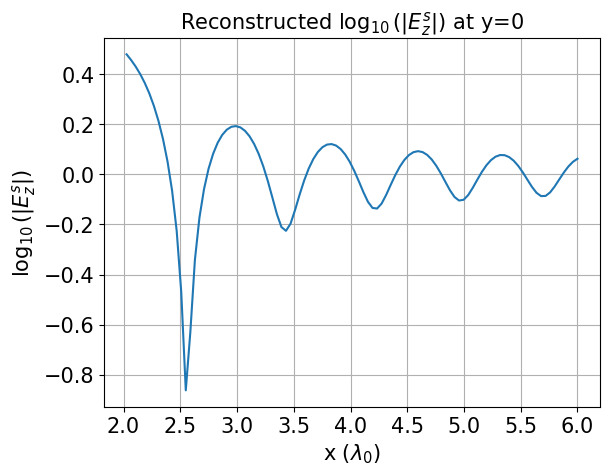

First minimum index: 213
First minimum value: -0.8627603853850373
X-coordinate of the minimum value: 2.5484949832775925


In [58]:
e_inv_scat_log = np.log10(np.abs(e_total_rectangle_sum))
# Get the indices where x_grid[N//2] > a_aux
indices = np.where(x_grid[N//2] > a_aux)[0]

# Filter x_grid[N//2] and e_inv_total_log[N//2] based on the condition
x_filtered = x_grid[N//2, indices]
e_filtered = e_inv_scat_log[N//2, indices]

# Plot the filtered data
plt.figure()
plt.plot(x_filtered, e_filtered)
plt.title(r'Reconstructed $\log_{10}(|E^{s}_{z}$|) at y=0', fontsize=15)
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'$\log_{10}(|E^{s}_{z}$|)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.show()

# Search for the first minimum value in e_inv_total_log[N//2]
min_index = None
min_value = np.inf
for i in indices:
    if e_inv_scat_log[N//2, i] < min_value:
        min_value = e_inv_scat_log[N//2, i]
        min_index = i

x_coordinate = x_grid[N//2, min_index]

print("First minimum index:", min_index)
print("First minimum value:", min_value)
print("X-coordinate of the minimum value:", x_coordinate)
